In [2]:
import datetime
import glob
import h3
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

#Set color palette in code
colors = ['#8468F5','#EC74E7','#B2B2B2','#FFCB5C','#46B6E8','#2FD4A1']
sns.set_palette(sns.color_palette(colors), n_colors = 6)

# Introduction

## Purpose
The idea of this project is to demostrate how to use's Uber's h3 hexagons to analyse location data. In this project we will use station and journey data from Helsinki city bikes.

## Helsinki city bikes
Helsinki city bike trips are often short, for example moving from metro station to target location and they are meant for making public transport more appealing by offering a quick way to transit between two locations. A user can grab a city bike from any station they want and return it to any city bike station they want (including full stations). City bikes are available roughly from March until October and a full season costs 35 euros (less than 40 US dollars). With the fixed fee one can use the city bikes as much as they want as long as the trip lasts less than 30 minutes. If the trip goes beyond 30 minutes, the user must pay 1 euro per every next 30 minutes. The user can also pay one-time trips but the cost is higher than with the seasonal subsciption.

## Uber hexagons
We will use Uber's hexagon system to cluster location data into certain size areas. More info can be found fro example Uber's blog: https://www.uber.com/en-FI/blog/h3/. We will use H3 library to map location data to geospatial indeces and tutorial for the package can be found from: https://h3geo.org/docs/. We will use h3 version 3.7.6 and the changes to version 4.x can be found from here: https://h3geo.org/docs/library/migration-3.x/functions.


## About the data
Helsinki city bikes journey data is available from 2016 to 2021 and the data is owned by City Bike Finland. One full season of data can be downloaded from `dev.hsl.fi/citybikes/od-trips-[year]/od-trips-[year].zip` by selecting the desired year, so for example http://dev.hsl.fi/citybikes/od-trips-2021/od-trips-2021.zip.

The info on the city bike stations can be downloaded from https://public-transport-hslhrt.opendata.arcgis.com/datasets/HSLHRT::helsingin-ja-espoon-kaupunkipyöräasemat-avoin/about.


### Data cleaning
The data columns are mixture of Finnish, Swedish and English so we translate all the relevant data to English.

There are also NaNs in essential features (for example station id or date) that we need to remove. There also some issues with the journey length (distance in meters) and duration (in seconds) that we need to take care of.

The data is not consisted throughout 2016-2021 and some stations ids from journey data cannot be found from stations data table which causes issues when merging trip data with stations data. All in all, we need to remove ~3% of journeys due to bad data quality.

We also add additional features to our data, including features derived from a date (hour, day, month, year, etc.) and hexagon ids with resolution 6 to 9 (corresponding areas with radiuses ~4km to 200m).

## Notebooks
In this project we have the following relevant notebooks:
1. `City-bikes-data-cleaning.ipynb`: cleaning and merging the data and saving it to one csv file.
2. `City-bikes-data-analysis.ipynb`: data analysis of the Helsinki city bike data.
3. `City-bikes-data-analysis-with-folium-maps.ipynb`: using folium package to plot interactive maps (time consuming and stiff method to analyse the data.)

# Stations data

In [3]:
file_path = './bike_data/city_bikes_stations.csv'
df_stations = pd.read_csv(file_path)

df_stations.head()

,FID,ID,Nimi,Namn,Name,Osoite,Adress,Kaupunki,Stad,Operaattor,Kapasiteet,x,y
0,1,501,Hanasaari,Hanaholmen,Hanasaari,Hanasaarenranta 1,Hanaholmsstranden 1,Espoo,Esbo,CityBike Finland,10,24.840319,60.165820
1,2,503,Keilalahti,Kägelviken,Keilalahti,Keilalahdentie 2,Kägelviksvägen 2,Espoo,Esbo,CityBike Finland,28,24.827467,60.171524
2,3,505,Westendinasema,Westendstationen,Westendinasema,Westendintie 1,Westendvägen 1,Espoo,Esbo,CityBike Finland,16,24.805758,60.168266
3,4,507,Golfpolku,Golfstigen,Golfpolku,Golfpolku 3,Golfstigen 3,Espoo,Esbo,CityBike Finland,16,24.796136,60.168143
4,5,509,Revontulentie,Norrskensvägen,Revontulentie,Revontulentie 10,Norrskensvägen 10,Espoo,Esbo,CityBike Finland,30,24.802938,60.171551


In [4]:
# Rename "x" and "y" as longitude and latitude
df_stations = df_stations.rename(columns={"x": "lng", "y": "lat"})

# Let's drop unnecessary columns:
df_stations = df_stations.drop(columns=['Name', 'Namn', 'Adress', 'Stad', 'Operaattor', 'FID'])

# Translate the column names to English:
df_stations = df_stations.rename(columns={"Osoite": "Address", "Kaupunki": "City", "Kapasiteet": "Capacity",
                                          "Nimi": "Name"})

# In 'City' column, blanks refer to Helsinki so let's fill in that name:
df_stations.loc[df_stations.City == ' ', 'City'] = 'Helsinki'

df_stations.head()

,ID,Name,Address,City,Capacity,lng,lat
0,501,Hanasaari,Hanasaarenranta 1,Espoo,10,24.840319,60.165820
1,503,Keilalahti,Keilalahdentie 2,Espoo,28,24.827467,60.171524
2,505,Westendinasema,Westendintie 1,Espoo,16,24.805758,60.168266
3,507,Golfpolku,Golfpolku 3,Espoo,16,24.796136,60.168143
4,509,Revontulentie,Revontulentie 10,Espoo,30,24.802938,60.171551


In [5]:
# Add hexagon ids of resolution 6 to 9 to the stations.
min_res = 6
max_res = 9
for ind in df_stations.index.tolist():
    lat = df_stations.loc[ind].lat
    lng = df_stations.loc[ind].lng
    for res in range(min_res, max_res+1):
        h3_id = h3.geo_to_h3(lat, lng, res)
        col = "h3_res"+str(res)
        df_stations.loc[ind, col] = h3_id

df_stations.head()

,ID,Name,Address,City,Capacity,lng,lat,h3_res6,h3_res7,h3_res8,h3_res9
0,501,Hanasaari,Hanasaarenranta 1,Espoo,10,24.840319,60.165820,86089969fffffff,87089969affffff,88089969a3fffff,89089969a33ffff
1,503,Keilalahti,Keilalahdentie 2,Espoo,28,24.827467,60.171524,86089969fffffff,870899698ffffff,8808996985fffff,8908996984fffff
2,505,Westendinasema,Westendintie 1,Espoo,16,24.805758,60.168266,86089969fffffff,87089969effffff,880899698dfffff,890899698dbffff
3,507,Golfpolku,Golfpolku 3,Espoo,16,24.796136,60.168143,86089969fffffff,87089969effffff,88089969ebfffff,89089969eb7ffff
4,509,Revontulentie,Revontulentie 10,Espoo,30,24.802938,60.171551,86089969fffffff,870899698ffffff,880899698dfffff,890899698d3ffff


# Trips data

Helsinki bike trips data is available in monthly csv files. Note that Helsinki bikes are not available during winter so we don't have any data from November to March.

We download all the available months and combine the data into one pandas dataframe.

In [6]:
# There are city bike data from 2016 until 2021. Note that bikes are not available during winter (November-March).
!ls ./bike_data/trips

2016-05.csv 2017-06.csv 2018-06.csv 2019-06.csv 2020-05.csv 2021-05.csv
2016-06.csv 2017-07.csv 2018-07.csv 2019-07.csv 2020-06.csv 2021-06.csv
2016-07.csv 2017-08.csv 2018-08.csv 2019-08.csv 2020-07.csv 2021-07.csv
2016-08.csv 2017-09.csv 2018-09.csv 2019-09.csv 2020-08.csv 2021-08.csv
2016-09.csv 2017-10.csv 2018-10.csv 2019-10.csv 2020-09.csv 2021-09.csv
2016-10.csv 2018-04.csv 2019-04.csv 2020-03.csv 2020-10.csv 2021-10.csv
2017-05.csv 2018-05.csv 2019-05.csv 2020-04.csv 2021-04.csv


In [7]:
# Read all the data into one pandas dataframe.

directory_path = './bike_data/trips'
all_files = glob.glob(os.path.join(directory_path , "*.csv"))

df_trips = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

trips_number_of_rows= len(df_trips)
df_trips.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/concat.py:348: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  objs = list(objs)


,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.)
0,2018-06-30T23:59:56,2018-07-01T00:12:00,44.0,Sörnäisten metroasema,70.0,Sammonpuistikko,3199.0,756.0
1,2018-06-30T23:59:33,2018-07-01T00:06:00,22.0,Rautatientori / länsi,22.0,Rautatientori / länsi,104.0,391.0
2,2018-06-30T23:59:27,2018-07-01T00:06:00,27.0,Eerikinkatu,63.0,Jätkäsaarenlaituri,1247.0,422.0
3,2018-06-30T23:59:23,2018-07-01T00:03:00,127.0,Teurastamo,125.0,Arielinkatu,791.0,227.0
4,2018-06-30T23:59:23,2018-07-01T00:07:00,27.0,Eerikinkatu,63.0,Jätkäsaarenlaituri,1251.0,485.0


In [12]:
print("Number of trips: ", len(df_trips))
print(" ")
print("----------------")
print("Number of NaN values in the dataframe:")
for col in df_trips.columns.tolist():
    print(col, df_trips[col].isnull().sum())

Number of trips:  15022833
 
----------------
Number of NaN values in the dataframe:
Departure 0
Return 0
Departure station id 665
Departure station name 665
Return station id 360
Return station name 360
Covered distance (m) 2531
Duration (sec.) 209264


### Clean the data and extract info from the date

In [13]:
len_before = len(df_trips)

# Drop rows where we have NaN values
df_trips = df_trips.dropna(subset=['Return station id', 'Departure station id', 'Departure', 'Return'])

# Check how many rows were removed:
print("Numbers of rows removed: ", len_before - len(df_trips))

# After filtering NaN, we can also change the timestamps into datetime
df_trips['Departure'] = pd.to_datetime(df_trips['Departure'])
df_trips['Return'] = pd.to_datetime(df_trips['Return'])

# Parse info from the timestamps: departure and return year, month, day, hour, ..
df_trips['departure_day_name'] = df_trips['Departure'].dt.day_name()
df_trips['departure_weekday'] = df_trips['Departure'].dt.dayofweek
df_trips['departure_hour'] = df_trips['Departure'].dt.hour
df_trips['departure_day'] = df_trips['Departure'].dt.day
df_trips['departure_month'] = df_trips['Departure'].dt.month
df_trips['departure_date'] = df_trips['Departure'].dt.date
df_trips['departure_year'] = df_trips['Departure'].dt.year

df_trips['return_day_name'] = df_trips['Return'].dt.day_name()
df_trips['return_weekday'] = df_trips['Return'].dt.dayofweek
df_trips['return_hour'] = df_trips['Return'].dt.hour
df_trips['return_day'] = df_trips['Return'].dt.day
df_trips['return_month'] = df_trips['Return'].dt.month
df_trips['return_date'] = df_trips['Return'].dt.date
df_trips['return_year'] = df_trips['Return'].dt.year

Numbers of rows removed:  1025


### Checking possible issues with distance or duration columns

In [10]:
print("Number of trips where covered distance is 0 meters:", len(df_trips[df_trips['Covered distance (m)'] == 0]))

Number of trips where covered distance is 0 meters: 465581


[Text(0, 0.5, 'Number of cases'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Number of trips per day where the covered distance is 0 meters.')]

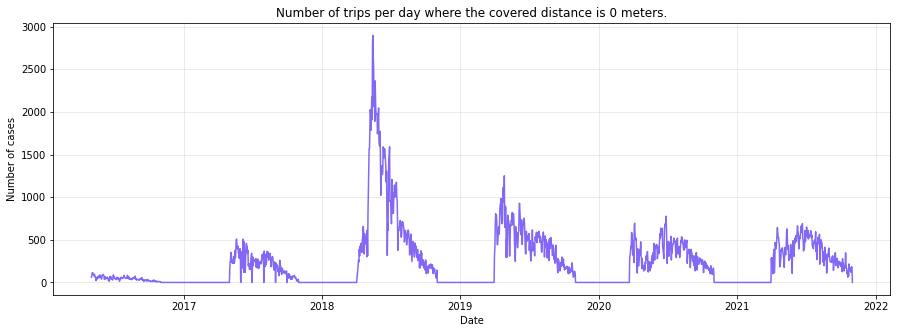

In [14]:
# Calculate the number of trips per day when the covered distance is 0m:
use_data = df_trips[df_trips['Covered distance (m)'] == 0].groupby(['departure_date'])\
                                                          .Departure.count().reset_index()

# In the above count we only take into accout days when there is at least one trip where covered distance is 0m.
# However, there are probably days when there isn't any of such trips. We need to expand the table with all the
# dates in the trips data and set the count to 0 when there's not any trips that has moved 0m.
timerange =  pd.date_range(df_trips['departure_date'].min(),
                           df_trips['departure_date'].max()+pd.Timedelta(days=1),
                           freq='1d')
all_slots = pd.DataFrame({'time':timerange})
all_slots['departure_date'] = all_slots['time'].dt.date
use_data = pd.merge(all_slots, use_data, how="left", on=['departure_date'])
use_data.Departure = use_data.Departure.fillna(0)


fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data, x='departure_date', y='Departure')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of cases', xlabel='Date', title = 'Number of trips per day where the covered distance is 0 meters.')

It seems that the cases with covered distance is 0m is quite equally spread accross the time (except small peak in 2018 but that doesn't seem to last long) so we can remove rows where covered distance is  0.

In [12]:
len_before = len(df_trips)

# There's a lot of trips that it seems like the bike has not moved at all. Perhaps these are cases where
# the unlocking failed or the user decided not to use the bike afterall.

# Let's only take into account those trips where covered distance is larger than 0.
df_trips = df_trips[df_trips['Covered distance (m)'] > 0]

print("Numbers of rows removed: ", len_before - len(df_trips))

Numbers of rows removed:  468148


Let's next check the trips where the duration is null.

In [13]:
print("Number of trips that has 'null' in duration:", len(df_trips[df_trips['Duration (sec.)'].isnull()]))

Number of trips that has 'null' in duration: 203934


[Text(0, 0.5, 'Number of cases'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Number of trips per day where the duration is null.')]

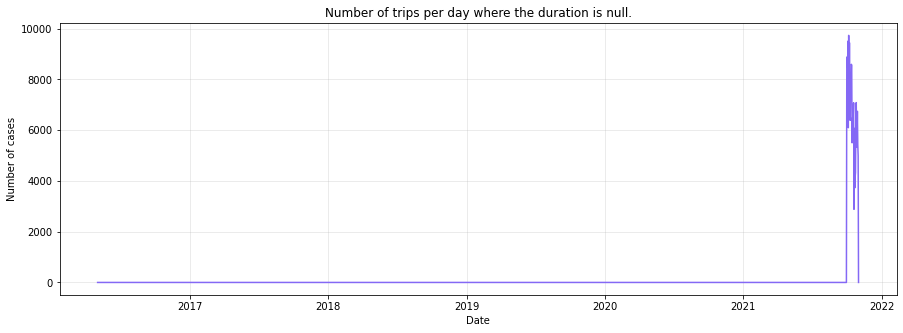

In [15]:
use_data = df_trips[df_trips['Duration (sec.)'].isnull()].groupby(['departure_date']).Departure.count().reset_index()

timerange =  pd.date_range(df_trips['departure_date'].min(),
                           df_trips['departure_date'].max()+pd.Timedelta(days=1), freq='1d')
all_slots = pd.DataFrame({'time':timerange})
all_slots['departure_date'] = all_slots['time'].dt.date
use_data = pd.merge(all_slots, use_data, how="left", on=['departure_date'])
use_data.Departure = use_data.Departure.fillna(0)


fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data, x='departure_date', y='Departure')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of cases', xlabel='Date', title = 'Number of trips per day where the duration is null.')

Deeper look into the data reveals that on October 2021 the duration is always null. There's probably some issues with the database on that month. If we remove these rows, we will remove all data from 10/2021. So let's keep these in the data.

In [17]:
# Let's look at the value count of null values throughout the data:
df_trips[df_trips['Duration (sec.)'].isnull()].groupby(['departure_year', 'departure_month']).Departure.count()

departure_year  departure_month
2018            5                       3
                8                       1
                9                       1
2021            10                 209240
Name: Departure, dtype: int64

In [18]:
print("Number of trips in October 2021:",
      len(df_trips[(df_trips.departure_year == 2021)&(df_trips.departure_month == 10)]))

Number of trips in October 2021: 209240


# Merging stations data with trip data

### First, we notice that the station ids from 2016 are different than in later years so we need to modify them.

In [17]:
# Checking the stations ids from 2016 we see that they are strings, not integers like they should.
# So the station indexation has been changed after 2016.
df_trips[(df_trips.departure_year == 2016)]['Departure station id'].unique()

array(['A27', 'A01', 'A40', 'B08', 'A25', 'A49', 'A24', 'B04', 'A07',
       'A38', 'A23', 'B07', 'A19', 'A42', 'A05', 'B05', 'A21', 'A03',
       'A18', 'A17', 'C01', 'A06', 'A30', 'A41', 'C02', 'B01', 'A29',
       'A10', 'A33', 'A31', 'A14', 'A35', 'A15', 'A22', 'A09', 'A32',
       'A28', 'B02', 'B03', 'A11', 'A12', 'A02', 'A26', 'A16', 'A34',
       'A13', '997', 'A20', 'A04', 'A39'], dtype=object)

In [18]:
df_trips[(df_trips.departure_year == 2021)]['Departure station id'].unique()

array([305, 361, 69, 24, 87, 237, 238, 129, 126, 145, 118, 394, 51, 6, 22,
       78, 761, 150, 625, 280, 127, 40, 403, 397, 313, 225, 306, 161, 103,
       113, 21, 226, 213, 31, 727, 281, 284, 29, 7, 115, 581, 70, 122,
       360, 272, 105, 241, 36, 9, 731, 203, 260, 344, 39, 34, 206, 63, 27,
       293, 32, 204, 8, 511, 517, 86, 393, 120, 751, 110, 16, 13, 262, 44,
       48, 95, 218, 121, 705, 53, 125, 259, 515, 112, 45, 346, 94, 111,
       162, 232, 589, 106, 17, 109, 100, 132, 214, 639, 41, 519, 10, 30,
       84, 322, 573, 647, 147, 404, 509, 553, 270, 571, 314, 38, 54, 333,
       140, 231, 138, 285, 283, 649, 352, 90, 131, 19, 529, 137, 1, 25,
       101, 627, 35, 119, 12, 73, 80, 555, 228, 72, 274, 11, 149, 117, 82,
       124, 148, 76, 401, 275, 247, 85, 543, 215, 49, 5, 733, 89, 263,
       635, 715, 202, 611, 719, 577, 65, 142, 55, 209, 57, 709, 99, 59,
       900, 368, 358, 14, 18, 42, 135, 77, 144, 230, 136, 23, 37, 370,
       116, 20, 330, 319, 279, 523, 15, 217, 372,

In [19]:
# In order to keep 2016 data in the data set, let's set a negative value to all stations that are from 2016.
df_trips.loc[(df_trips.departure_year == 2016), 'Departure station id'] = -1
df_trips.loc[(df_trips.departure_year == 2016), 'Return station id'] = -1

### Now we can combine the trip data with the stations data.

In [20]:
# Station ids must be integers. Let's drop all values that cannot be transformed into integer. Note that we
# set the station ids from 2016 to -1 as the id system has changed and the old station ids are not integers
# but we want to keep the data from 2016 still.
df_trips['Return station id'] = pd.to_numeric(df_trips['Return station id'], errors='coerce')
df_trips = df_trips[df_trips['Return station id'].notna()]
df_trips['Return station id'] = df_trips['Return station id'].astype(int)

df_trips['Departure station id'] = pd.to_numeric(df_trips['Departure station id'], errors='coerce')
df_trips = df_trips[df_trips['Departure station id'].notna()]
df_trips['Departure station id'] = df_trips['Departure station id'].astype(int)

departure_stations = df_stations[['ID', 'lng', 'lat', 'h3_res6', 'h3_res7', 'h3_res8', 'h3_res9']]
departure_stations.columns = "departure_"+departure_stations.columns

return_stations = df_stations[['ID', 'lng', 'lat', 'h3_res6', 'h3_res7', 'h3_res8', 'h3_res9']]
return_stations.columns = "return_"+return_stations.columns


df_trips = pd.merge(df_trips, departure_stations, how="left", left_on='Departure station id',
                    right_on='departure_ID')
df_trips = pd.merge(df_trips, return_stations, how="left", left_on = 'Return station id',
                    right_on='return_ID')
df_trips.head()

,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.),departure_day_name,departure_weekday,departure_hour,departure_day,departure_month,departure_date,departure_year,return_day_name,return_weekday,return_hour,return_day,return_month,return_date,return_year,departure_ID,departure_lng,departure_lat,departure_h3_res6,departure_h3_res7,departure_h3_res8,departure_h3_res9,return_ID,return_lng,return_lat,return_h3_res6,return_h3_res7,return_h3_res8,return_h3_res9
0,2018-06-30 23:59:56,2018-07-01 00:12:00,44,Sörnäisten metroasema,70,Sammonpuistikko,3199.0,756.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,44.0,24.960554,60.187713,861126d07ffffff,871126d06ffffff,881126d061fffff,891126d0603ffff,70.0,24.922411,60.173147,861126d37ffffff,871126d30ffffff,881126d303fffff,891126d3027ffff
1,2018-06-30 23:59:33,2018-07-01 00:06:00,22,Rautatientori / länsi,22,Rautatientori / länsi,104.0,391.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,22.0,24.939760,60.170606,861126d37ffffff,871126d33ffffff,881126d331fffff,891126d338fffff,22.0,24.939760,60.170606,861126d37ffffff,871126d33ffffff,881126d331fffff,891126d338fffff
2,2018-06-30 23:59:27,2018-07-01 00:06:00,27,Eerikinkatu,63,Jätkäsaarenlaituri,1247.0,422.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,27.0,24.936642,60.167706,861126d37ffffff,871126d33ffffff,881126d339fffff,891126d338bffff,63.0,24.921490,60.161931,861126d37ffffff,871126d30ffffff,881126d307fffff,891126d307bffff
3,2018-06-30 23:59:23,2018-07-01 00:03:00,127,Teurastamo,125,Arielinkatu,791.0,227.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,127.0,24.971157,60.189695,861126d07ffffff,871126d06ffffff,881126d063fffff,891126d063bffff,125.0,24.979739,60.185922,861126d07ffffff,871126d02ffffff,881126d067fffff,891126d066fffff
4,2018-06-30 23:59:23,2018-07-01 00:07:00,27,Eerikinkatu,63,Jätkäsaarenlaituri,1251.0,485.0,Saturday,5,23,30,6,2018-06-30,2018,Sunday,6,0,1,7,2018-07-01,2018,27.0,24.936642,60.167706,861126d37ffffff,871126d33ffffff,881126d339fffff,891126d338bffff,63.0,24.921490,60.161931,861126d37ffffff,871126d30ffffff,881126d307fffff,891126d307bffff


In [21]:
# Check that we have data from all the years
df_trips.departure_year.value_counts()

2019    3787889
2018    3227348
2020    3129260
2021    2862102
2017    1607052
2016     408156
Name: departure_year, dtype: int64

### Let's also add info to the stations data that in which year the station was first and last used.

In [22]:
# Add year to df_stations on when the station was first time used
stations_info = df_trips.groupby([pd.to_datetime(df_trips['Departure']).dt.year, 'Departure station id'])\
                        .Return.count()\
                        .reset_index()\
                        .rename(columns= {'Departure':'Year', 'Departure station id':'ID'})\
                        .drop(columns=['Return']).sort_values(by=['Year'], ascending=True)\
                        .drop_duplicates(subset=['ID'], keep='first')
df_stations = df_stations.merge(stations_info, how='left', on='ID')

# The station id is different in 2016 than in the later years so we cannot use the station id from 2016 to combine
# trips and stations. Instead we must use the station names (not fully accurate, some names are changed).
stations = df_trips[pd.to_datetime(df_trips['Departure']).dt.year == 2016]['Departure station name'].unique()\
                                                                                                    .tolist()
df_stations.loc[df_stations.Name.isin(stations), 'Year'] = 2016

# Add the last year when the station was still used
stations_info = df_trips.groupby([pd.to_datetime(df_trips['Departure']).dt.year, 'Departure station id']).Return\
                        .count().reset_index()\
                        .rename(columns= {'Departure':'Year_last_used', 'Departure station id':'ID'})\
                        .drop(columns=['Return']).sort_values(by=['Year_last_used'], ascending=False)\
                        .drop_duplicates(subset=['ID'], keep='first')
df_stations = df_stations.merge(stations_info, how='left', on='ID')

df_stations.head()

,ID,Name,Address,City,Capacity,lng,lat,h3_res6,h3_res7,h3_res8,h3_res9,Year,Year_last_used
0,501,Hanasaari,Hanasaarenranta 1,Espoo,10,24.840319,60.165820,86089969fffffff,87089969affffff,88089969a3fffff,89089969a33ffff,2018,2021
1,503,Keilalahti,Keilalahdentie 2,Espoo,28,24.827467,60.171524,86089969fffffff,870899698ffffff,8808996985fffff,8908996984fffff,2018,2021
2,505,Westendinasema,Westendintie 1,Espoo,16,24.805758,60.168266,86089969fffffff,87089969effffff,880899698dfffff,890899698dbffff,2018,2021
3,507,Golfpolku,Golfpolku 3,Espoo,16,24.796136,60.168143,86089969fffffff,87089969effffff,88089969ebfffff,89089969eb7ffff,2018,2021
4,509,Revontulentie,Revontulentie 10,Espoo,30,24.802938,60.171551,86089969fffffff,870899698ffffff,880899698dfffff,890899698d3ffff,2018,2021


In [23]:
# Amount of stations added each year:
df_stations.Year.value_counts()

2018    117
2021    106
2017     97
2019     94
2016     41
2020      2
Name: Year, dtype: int64

In [24]:
# The year that the stations was last used:
df_stations.Year_last_used.value_counts()

2021    456
2020      1
Name: Year_last_used, dtype: int64

In [25]:
# The data shows only one station has been removed (latest usage in 2021):
df_stations[df_stations.Year_last_used < 2021]

,ID,Name,Address,City,Capacity,lng,lat,h3_res6,h3_res7,h3_res8,h3_res9,Year,Year_last_used
89,729,Leppävaaranaukio,Hevosenkenkä 3,Espoo,30,24.813885,60.218869,86089968fffffff,87089968affffff,88089968abfffff,89089968aabffff,2018,2020


This might mean that actually stations data show only stations that were recently available, not all stations that has been available.

## Check how much data per each day we removed.

There are clearly more issues in the older data (especially from 2016) than from the more recent data.

[Text(0, 0.5, 'Number of cases'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Number of trips where that have issues with stations.')]

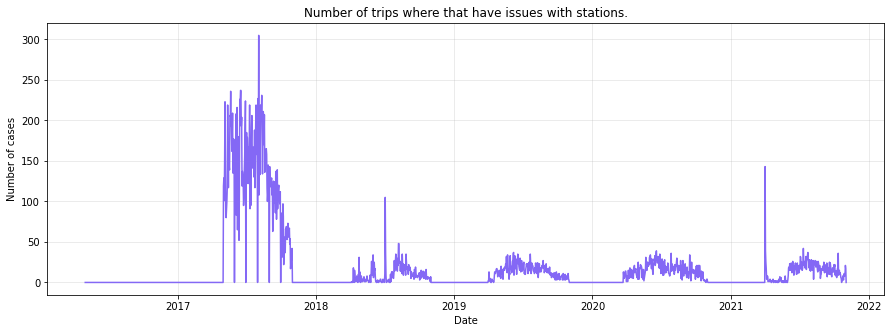

In [23]:
use_data = df_trips[df_trips.departure_year >= 2017]
use_data = use_data[(use_data.departure_h3_res8.isnull()) | (use_data.return_h3_res8.isnull())]
use_data = use_data.groupby(['departure_date']).Departure.count().reset_index()

timerange =  pd.date_range(df_trips['departure_date'].min(),
                           df_trips['departure_date'].max()+pd.Timedelta(days=1), freq='1d')
all_slots = pd.DataFrame({'time':timerange})

all_slots['departure_date'] = all_slots['time'].dt.date
use_data = pd.merge(all_slots, use_data, how="left", on=['departure_date'])
use_data.Departure = use_data.Departure.fillna(0)

use_data = use_data.groupby(['departure_date']).mean().reset_index()


fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data, x='departure_date', y='Departure')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of cases', xlabel='Date',
       title = "Number of trips where that have issues with stations.")

## Check the station names from trips data that we couldn't find from the stations data 

In [27]:
# Let's check the stations names that were not found from the stations data table (do they don't have hexagon ids.)
df_trips[(df_trips.departure_year >= 2017)&(df_trips.departure_h3_res8.isnull())]['Departure station name'].unique()

array(['Workshop Helsinki', 'Kalastajantie', 'Adjutantinkatu',
       'Leiritori', 'Kauppakartanonkuja', 'Workshop Konala',
       ' Relay Box test station', 'Suomenlahdentie', 'Piispansilta',
       'Lintumetsä', 'Olarinkatu', 'Friisinkalliontie', 'Professorintie',
       'Matinkartanontie', 'Kuunkatu', 'Ruomelantie', 'Niemenmäenkuja',
       'Nokkala', 'Sepetlahdentie', 'Workshop Smoove', 'Ruomelantie***',
       'Bike Production', '9 Station Test'], dtype=object)

Seems that some of the stations are workshops and test stations but it seems that some of the names sound like actual bike stations. The reason why they cannot be found from the stations data table is unknown but perhaps they have slightly changed their name or station id.

In [28]:
# I found one station that have actually changed the ids but has kept the same name. However I cannot be sure if
# there's been some changes to the station so it's safer to remove it.
df_trips[df_trips['Departure station name'] == 'Kuunkatu']['Departure station id'].unique()

array([635, 153])

In [29]:
len_before = len(df_trips)

# Some trips have stations that are not in the stations data table. Let's drop those that are from 2017 onwards.
df_trips = df_trips[((df_trips.departure_h3_res8.notnull())&(df_trips.departure_year >= 2017)) | 
                    (df_trips.departure_year == 2016)]
df_trips = df_trips[((df_trips.return_h3_res8.notnull()) & (df_trips.departure_year >= 2017)) |
                    (df_trips.departure_year == 2016)]

print("Numbers of rows removed: ", len_before - len(df_trips))

Numbers of rows removed:  34203


In [30]:
# Number of rows 
dropped_rows = trips_number_of_rows - len(df_trips)
print("We dropped ", dropped_rows, "rows which is ", 100*dropped_rows/trips_number_of_rows,  "% of all the data.")

We dropped  503377 rows which is  3.350746160860605 % of all the data.


## Saving the result to csv files

In [31]:
df_trips.to_csv('bike_data/city-bike-trips-cleaned.csv', index=False)
df_stations.to_csv('bike_data/city-bike-stations-cleaned.csv', index=False)